In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
import geoplot as gplt
import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_3"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}



In [46]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)




vehicleData_pick_and_drop = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicles_pick_and_drop = initializeVehicles(startIndices=startNodeIndeces*2,vehicleData=vehicleData_pick_and_drop,
                                                            routingContext=routingContext)



customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)
initial_solution_pick_and_drop = cheapest_insertion_dict(locationNodeIndeces,vehicles_pick_and_drop,endNodeIndeces,routingContext)


cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_multi_objective_pick_and_drop = {'routing_context':routingContext,'vehicles':vehicles_pick_and_drop,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution_pick_and_drop,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 1
amount_of_evaluations = 10000
observer_update_interval = 1
logpath = "parameter_data/{}".format(dataset)
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
parameters_NSGAIII = optimal_parameters["NSGAIII"]
       


In [47]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# NSGA-III

In [23]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator



plot_data_NSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_NSGAIII = VRP(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)

    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])



nsga3_numerical_path_normal = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:1 of 1
Evaluations: 10000/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20} 
IGD:352.0111136678002
Best fitness: 254.4112 --- 243.2833                        
Best total fuel consumption:254.41 
Computing time: 13.29s                        
Average computing speed: 752.32it/s
Current Route:[['V0', 17, 24, 3, 70, 32], ['V3', 72, 39, 59, 29, 30, 71, 57, 4], ['V2', 18, 47, 74, 23, 53, 5], ['V4', 34, 13, 7, 65, 64, 48, 62, 1], ['V8', 46, 50, 8, 43, 26, 2], ['V6', 11, 14, 73, 58, 51, 20], ['V7', 66, 12, 54, 37, 19, 2], ['V10', 55, 4], ['V12', 9, 36, 75, 56, 27, 22, 20], ['V13', 69, 42, 5], ['V14', 44, 2], ['V15', 16, 63, 2], ['V18', 25, 28, 49, 52, 33, 38, 61, 41, 4], ['V19', 67, 4]]
Flags: []                        
Violation:0
Vehicle amount:14


In [24]:
get_solution_results(front_NSGAIII[0],routingContext,vehicles)

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,91.166,02:31:23,2355.0,13.907400,15.255030,36.133172
1,176.505,03:51:02,3725.0,30.475629,17.266156,45.838840
2,142.669,03:14:15,2443.0,21.340043,14.957730,44.067645
3,113.958,03:05:47,3561.0,18.246390,16.011504,36.803517
4,118.318,02:44:13,2469.0,17.876460,15.108825,43.229960
5,194.844,04:00:45,2282.0,29.104129,14.937144,48.559252
6,150.156,03:31:48,2545.0,24.724349,16.465775,42.537110
7,49.643,01:51:04,1191.0,8.810388,17.747492,26.817947
8,143.440,03:44:13,2972.0,22.913508,15.974280,38.384301
9,63.257,01:44:13,1432.0,11.003530,17.394961,36.418551


# With Pick and Drop

In [49]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator


plot_data_NSGAIII_pick_and_drop = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_NSGAIII_pick_and_drop = VRP_pickup_and_drop(data_model_input_multi_objective_pick_and_drop)
    problem_NSGAIII_pick_and_drop.name = "NSGA-III"
    problem_NSGAIII_pick_and_drop.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII_pick_and_drop = NSGAIII(problem=problem_NSGAIII_pick_and_drop,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII_pick_and_drop = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII_pick_and_drop.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII_pick_and_drop.currentEpoch =  x

    algorithm_NSGAIII_pick_and_drop.observable.register(observer=performance_observer_NSGAIII_pick_and_drop)
    algorithm_NSGAIII_pick_and_drop.run()

    solutions_NSGAIII_pick_and_drop = algorithm_NSGAIII_pick_and_drop.get_result()
    front_NSGAIII_pick_and_drop = get_non_dominated_solutions(solutions_NSGAIII_pick_and_drop)

    store_plot_data(plot_data_NSGAIII_pick_and_drop,performance_observer_NSGAIII_pick_and_drop,front_NSGAIII_pick_and_drop[0])



nsga3_numerical_path_pick_and_drop = get_numerical_path(front_NSGAIII_pick_and_drop[0].path,vehicles_pick_and_drop)


Epoch:1 of 1
Evaluations: 10000/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20} 
IGD:344.5890810300451
Best fitness: 244.0386 --- 243.2833                        
Best total fuel consumption:244.04 
Computing time: 16.4s                        
Average computing speed: 609.69it/s
Current Route:[['V0', 17, 24, 47, 18, 74, 23, 53, 5], ['V1', 3, 32], ['V2', 34, 13, 7, 65, 64, 48, 62, 1], ['V3', 11, 14, 73, 58, 51, 20], ['V5', 70, 55, 4], ['V6', 9, 36, 75, 56, 27, 22, 20], ['V7', 44, 2], ['V9', 25, 28, 49, 52, 33, 38, 61, 41, 4], ['V10', 66, 32], ['V11', 72, 59, 29, 30, 71, 57, 39, 5], ['V12', 46, 50, 8, 43, 26, 2], ['V13', 12, 54, 37, 19, 2], ['V16', 42, 69, 5], ['V17', 16, 63, 2], ['V19', 67, 4]]
Flags: ['overload']                        
Violation:0
Vehicle amount:15


In [26]:
get_solution_results(front_NSGAIII_pick_and_drop[0],routingContext,vehicles_pick_and_drop)

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,142.332,03:50:54,3562.0,22.230210,15.618561,36.985362
1,39.321,49:23,707.0,5.896424,14.995611,47.774418
2,113.958,03:05:47,3561.0,18.246390,16.011504,36.803517
3,194.844,04:00:45,2282.0,29.104129,14.937144,48.559252
4,54.797,02:22:11,1720.0,10.796116,19.702021,23.123807
5,143.440,03:44:13,2972.0,22.913508,15.974280,38.384301
6,87.899,01:58:17,1409.0,12.600510,14.335214,44.587347
7,189.494,03:46:54,2939.0,31.631231,16.692471,50.108594
8,53.653,01:06:52,486.0,7.721222,14.391035,48.143270
9,149.976,03:32:51,3725.0,23.778028,15.854556,42.276533


In [34]:
front_NSGAIII_pick_and_drop[0].total_DriveTime

2297.483333333333

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

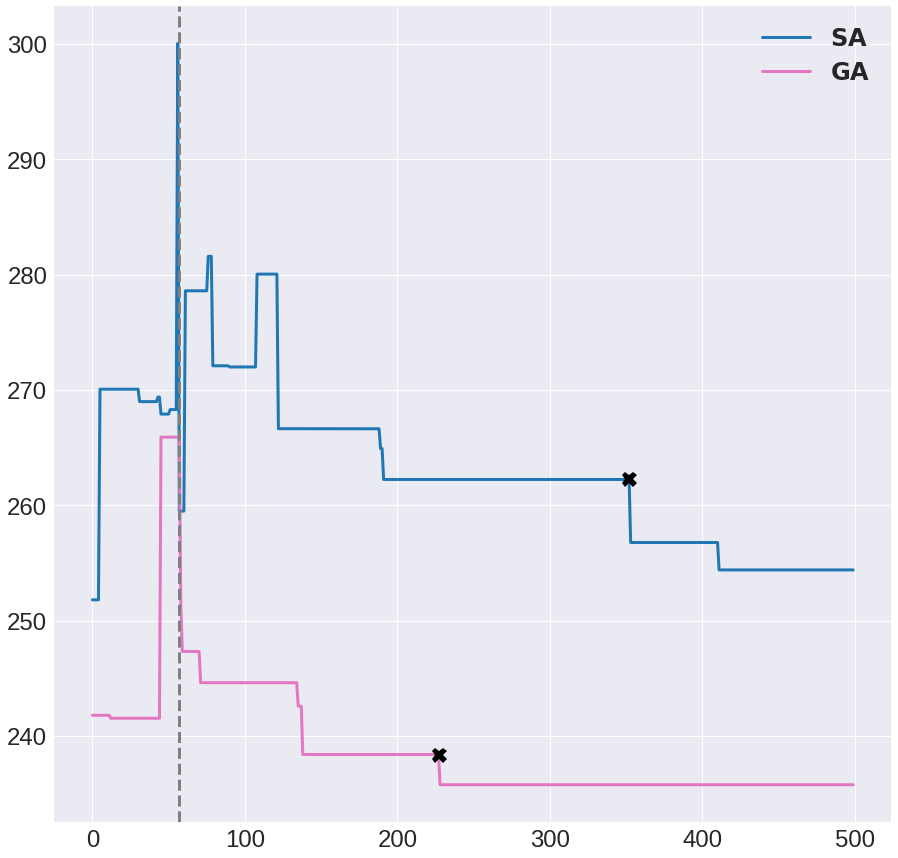

In [35]:
normal_method = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
pick_and_drop = np.mean(plot_data_NSGAIII_pick_and_drop["fuel_consumption"],axis=0)

curves = np.array([normal_method,pick_and_drop])
lables =["SA","GA"]




plot_conv_curves(curves,lables)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

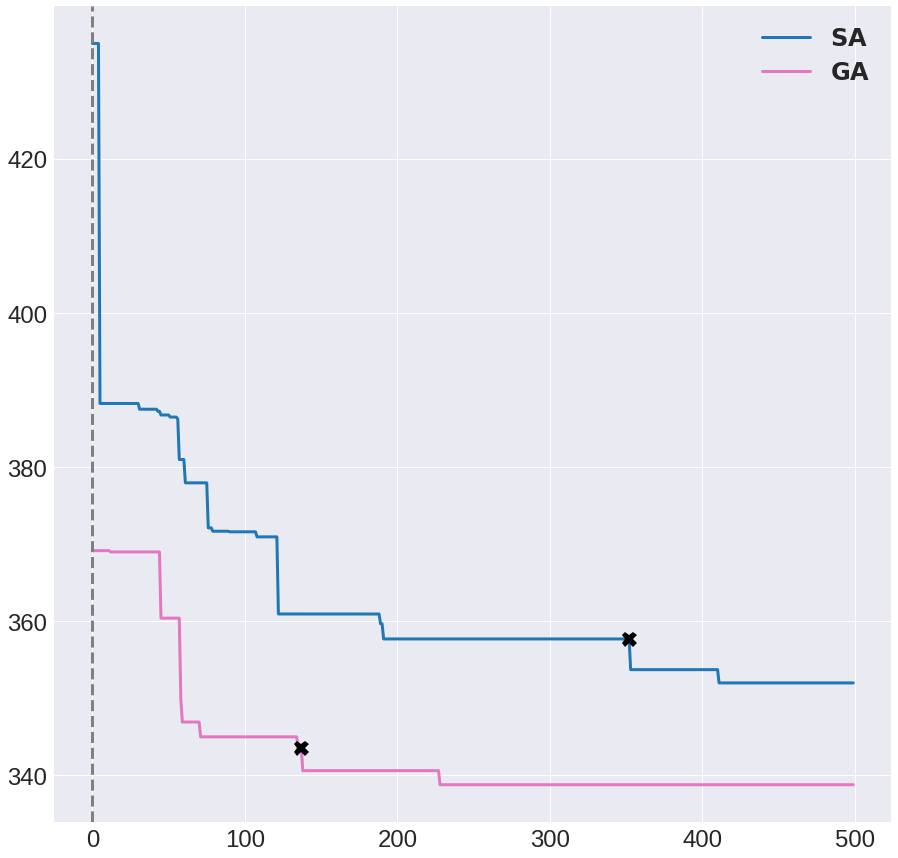

In [36]:
normal_method = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
pick_and_drop = np.mean(plot_data_NSGAIII_pick_and_drop["distance_to_origin"],axis=0)

curves = np.array([normal_method,pick_and_drop])
lables =["SA","GA"]




plot_conv_curves(curves,lables)

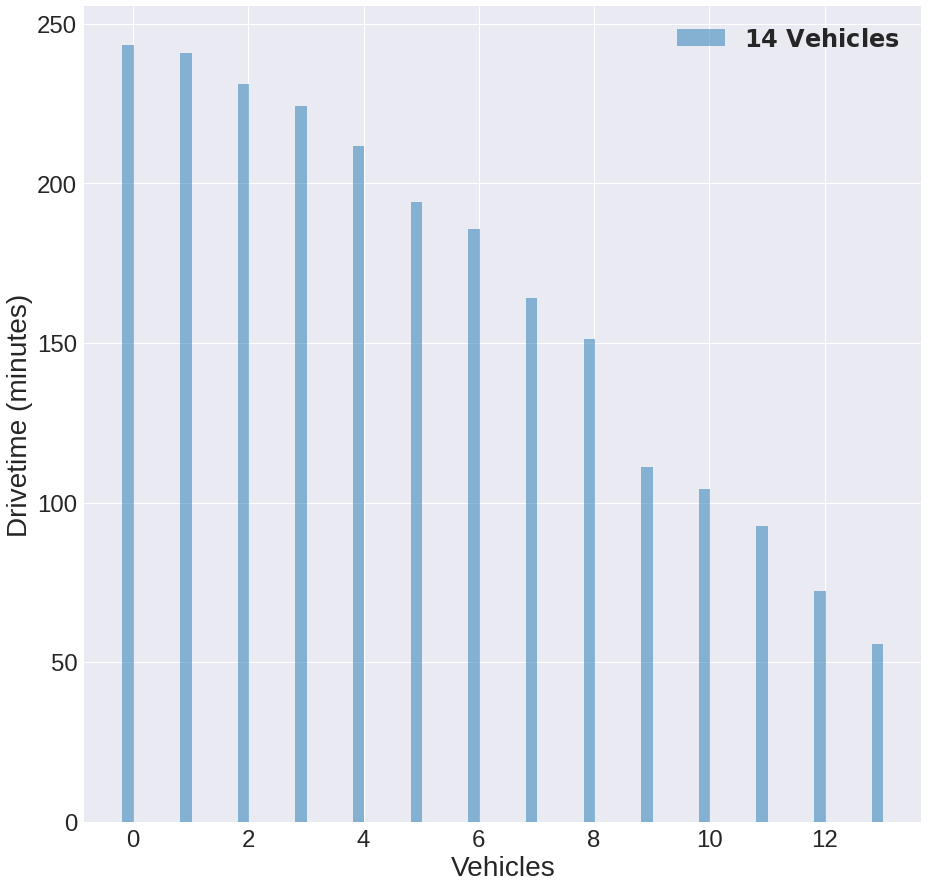

In [37]:
normal_df = pd.DataFrame(plot_data_NSGAIII)
normal_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in normal_df.iterrows()]
routes = normal_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
normal_df["Parameter Group"] = 1
normal_best = normal_df.head(1)
plot_vehicle_drivetimes(normal_best,1)

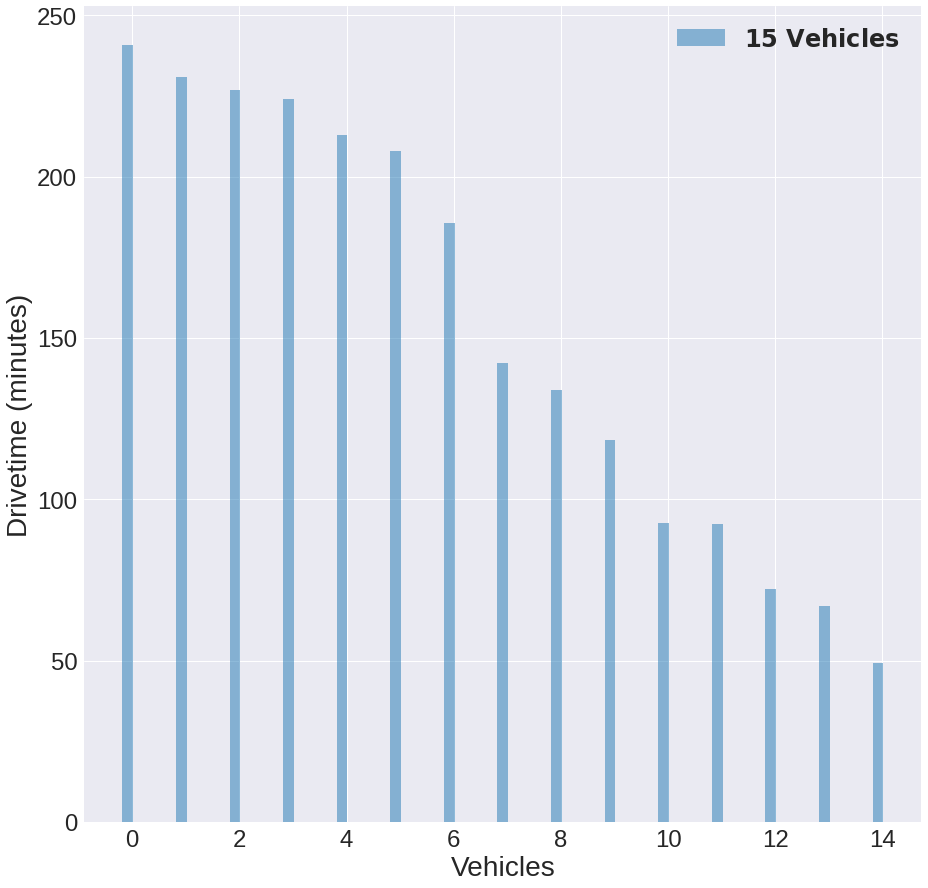

In [38]:
pick_and_drop_df = pd.DataFrame(plot_data_NSGAIII_pick_and_drop)
pick_and_drop_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in pick_and_drop_df.iterrows()]
routes = pick_and_drop_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
pick_and_drop_df["Parameter Group"] = 1
pick_and_drop_best = pick_and_drop_df.head(1)
plot_vehicle_drivetimes(pick_and_drop_best,1)

In [32]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = nsga3_numerical_path_normal
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [33]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = nsga3_numerical_path_pick_and_drop
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
